<a href="https://colab.research.google.com/github/joaocassella/MVP_ML/blob/main/ML_MVP_Notebook_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Notebook B
# Professores :
  * Tatiana Escovedo
  * Augusto Baffa
  * Luiz Schirmer

# Aluno : João Cassella

##Definição do Problema
1O problema proposto é a classificação de emails entre spam ou não spam, a partir da análise da mensagem.

Foi utilizado o dataset E-Mail classification NLP hospedado em no site kaggle, [Clique aqui](https://www.kaggle.com/datasets/datatattle/email-classification-nlp) para acessar a página do dataset.

O conjunto de dados é composto de 2 datasets, um de treino e outro de testes, ambos no formato csv

##Informações sobre os atributos

O dataset contém 3 atributos descritos a seguir :

* nr - Número da linha
* mensagem - Texto da mensagem do email (corpo do email)
* classe - Classificação (Spam / Non-Spam)


##Importação das bibliotecas



In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from tensorflow.random import set_seed

import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler

nltk.download('stopwords')
stop_words = stopwords.words('english')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Datasets

### Carga Treino e Teste

In [2]:
# Carregando os datasets de treino e teste

treino = pd.read_csv("https://raw.githubusercontent.com/joaocassella/MVP_ML/main/SMS_train.csv", delimiter=',',encoding='latin-1')
teste = pd.read_csv("https://raw.githubusercontent.com/joaocassella/MVP_ML/main/SMS_test.csv", delimiter=',',encoding='latin-1')

print(treino.head())

print(teste.head())


   sn                                           mensagem    classe
0   1                         Rofl. Its true to its name  Non-Spam
1   2  The guy did some bitching but I acted like i'd...  Non-Spam
2   3  Pity, * was in mood for that. So...any other s...  Non-Spam
3   4              Will Ã¼ b going to esplanade fr home?  Non-Spam
4   5  This is the 2nd time we have tried 2 contact u...      Spam
   sn                                           mensagem classe
0   1  UpgrdCentre Orange customer, you may now claim...   Spam
1   2  Loan for any purpose Â£500 - Â£75,000. Homeown...   Spam
2   3  Congrats! Nokia 3650 video camera phone is you...   Spam
3   4  URGENT! Your Mobile number has been awarded wi...   Spam
4   5  Someone has contacted our dating service and e...   Spam


### Informações

In [3]:
# Exibindo as dimensões dos datasets
print("Dataset de treino : ",treino.shape)
print()
print("Dataset de teste : ",teste.shape)

Dataset de treino :  (957, 3)

Dataset de teste :  (125, 3)


In [4]:
# Exibindo as informações dos Datasets
print("Dataset de treino : ",treino.describe())
print()
print("Dataset de teste : ",teste.describe())


Dataset de treino :                 sn
count  957.000000
mean   479.000000
std    276.406404
min      1.000000
25%    240.000000
50%    479.000000
75%    718.000000
max    957.000000

Dataset de teste :                 sn
count  125.000000
mean    63.000000
std     36.228442
min      1.000000
25%     32.000000
50%     63.000000
75%     94.000000
max    125.000000


###Preparação

In [5]:
# Substituindo os valores da coluna classe nos 2 datasets, para 0-1

treino['classe'] = treino['classe'].replace({"Non-Spam": 0, "Spam": 1})
teste['classe'] = teste['classe'].replace({"Non-Spam": 0, "Spam": 1})

print("Dataset de treino : ",treino.head())
print()
print("Dataset de teste : ",teste.head())

Dataset de treino :     sn                                           mensagem  classe
0   1                         Rofl. Its true to its name       0
1   2  The guy did some bitching but I acted like i'd...       0
2   3  Pity, * was in mood for that. So...any other s...       0
3   4              Will Ã¼ b going to esplanade fr home?       0
4   5  This is the 2nd time we have tried 2 contact u...       1

Dataset de teste :     sn                                           mensagem  classe
0   1  UpgrdCentre Orange customer, you may now claim...       1
1   2  Loan for any purpose Â£500 - Â£75,000. Homeown...       1
2   3  Congrats! Nokia 3650 video camera phone is you...       1
3   4  URGENT! Your Mobile number has been awarded wi...       1
4   5  Someone has contacted our dating service and e...       1


In [6]:
# Checando se existem valores nulos
print("Dataset de treino : ",treino.isna().sum())
print()
print("Dataset de teste : ",teste.isna().sum())

Dataset de treino :  sn          0
mensagem    0
classe      0
dtype: int64

Dataset de teste :  sn          0
mensagem    0
classe      0
dtype: int64


In [7]:
# Contando as ocorrências dos domínios 0 e 1 na coluna classe
print("Dataset de treino : ")
print(treino['classe'].value_counts())

print()
print("Dataset de teste : ")
print(teste['classe'].value_counts())

Dataset de treino : 
0    835
1    122
Name: classe, dtype: int64

Dataset de teste : 
1    76
0    49
Name: classe, dtype: int64


In [8]:
# Percebemos que o dataset de treino está desbalanceado pois possui quase 8x mais registros classificados como Não-Spam(0)
# Faremos então o balanceamento do dataset de treino

df_balanceado = treino.loc[treino['classe'] == 1]

max_size = len(df_balanceado)

categorias = [0, 1]

for cat in categorias:
    df_temp = treino.loc[treino['classe'] == cat]
    df_temp = df_temp.sample(n = max_size)

    df_balanceado = pd.concat([df_balanceado, df_temp])

treino = df_balanceado

print(treino['classe'].value_counts())
print(df_balanceado['classe'].value_counts())
print(df_balanceado.head())

1    244
0    122
Name: classe, dtype: int64
1    244
0    122
Name: classe, dtype: int64
    sn                                           mensagem  classe
4    5  This is the 2nd time we have tried 2 contact u...       1
5    6  REMINDER FROM O2: To get 2.50 pounds free call...       1
30  31  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...       1
33  34  Want explicit SEX in 30 secs? Ring 02073162414...       1
44  45  PRIVATE! Your 2003 Account Statement for shows...       1


In [9]:
# Contando as ocorrências dos domínios 0 e 1 na coluna classe
print("Dataset de treino : ")
print(treino['classe'].value_counts())

print()
print("Dataset de teste : ")
print(teste['classe'].value_counts())

Dataset de treino : 
1    244
0    122
Name: classe, dtype: int64

Dataset de teste : 
1    76
0    49
Name: classe, dtype: int64


### Limpeza dos dados

In [10]:
# Utilizaremos o método stop_words para retirar as palavras que possuem pouco valor semântico e que aparecem com
# frequência nas mensagens tais como : preposições, artigos e conjunções.

STOPWORDS = stopwords.words("english")

In [11]:
# Definindo a função de que fará a normalização dos textos nos datasets :
# 1. Converteremos todos os caracteres para caixa baixa
# 2. Substuiremos alguns termos que não tem valor semântico tais como htts, https, etc
# 3. Aplicaremos o método stop_words carregado acima

def f_limpeza(text):
    text = text.lower()
    text = re.sub("(http|https|www)(:|\.)\S+.com"," ",text)
    text = re.sub("[^\w\d]"," ",text)
    text = " ".join([t for t in text.split() if t not in STOPWORDS])
    return text

# Aplicaremos a função de normalização f_limpeza() tanto no dataset de treino quanto de teste
treino['msg_limpa'] = treino['mensagem'].apply(f_limpeza)

teste['msg_limpa'] = teste['mensagem'].apply(f_limpeza)

treino['msg_limpa'][:5]


4     2nd time tried 2 contact u u â 750 pound prize...
5     reminder o2 get 2 50 pounds free call credit d...
30    asked 3mobile 0870 chatlines inclu free mins i...
33    want explicit sex 30 secs ring 02073162414 cos...
44    private 2003 account statement shows 800 un re...
Name: msg_limpa, dtype: object

In [12]:
# Hyperpametros
vocab_size = 5000
max_len = 30

seed = 7
np.random.seed(seed)
set_seed(seed)

In [13]:
# Tokenização e padding

token = Tokenizer(num_words=vocab_size)
token.fit_on_texts(treino['msg_limpa'])

x_train = token.texts_to_sequences(treino['msg_limpa'])

x_test = token.texts_to_sequences(teste['msg_limpa'])

x_test = teste['msg_limpa'].apply(lambda x : f_limpeza(x))
x_test = token.texts_to_sequences(x_test)


x_train = treino['msg_limpa'].apply(lambda x : f_limpeza(x))
x_train = token.texts_to_sequences(x_train)

x_test = pad_sequences(x_test,padding='pre',truncating='pre',maxlen=max_len)
x_train = pad_sequences(x_train,maxlen=max_len,padding='pre',truncating='pre')


# Aplicando oversampling no dataset de treino
ros = RandomOverSampler(random_state=42)
x_train = pad_sequences(x_train,maxlen=max_len,padding='pre',truncating='pre')
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, treino['classe'])



## Criação da Rede Neural


Criaremos uma rede neural sequencial composta por camadas empilhadas, utilizando a biblioteca Keras/TensorFlow.

A arquitetura da rede neural é composta das seguintes camadas :

1. Camada de Embedding: Essa camada recebe como entrada um vetor de palavras e mapeia cada palavra para um vetor denso de tamanho 100. A entrada possui comprimento máximo definido.

2. Camada de Dropout: Essa camada aplica a técnica de regularização e desativa aleatoriamente uma porcentagem dos neurônios durante o treinamento.

3. Camada LSTM: Essa camada é uma camada de Memória de Longo Prazo Recorrente especializada em processar sequências de dados com dependências de longo prazo.

4. Camada de Dropout: Outra camada de Dropout é adicionada após a camada LSTM, com a mesma taxa de dropout da camada anterior.

5. Camada Dense: A camada Dense possui um único neurônio com função de ativação sigmoid, que produz uma saída binária (0 ou 1).

O modelo é compilado com uma função de perda binária_crossentropy, um otimizador Adam e a métrica de precisão para avaliação do desempenho.

####  Inicialização da RN

###Identificação dos melhores Hiperparâmetros

In [14]:
def f_modelo(dropout_rate, lstm_units):
    seed = 7
    np.random.seed(seed)
    set_seed(seed)

    model = Sequential([
        Embedding(vocab_size, 100, input_length=max_len),
        Dropout(dropout_rate),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = KerasClassifier(build_fn=f_modelo)

param_dist = {
    'dropout_rate': uniform(0.2, 0.3),
    'lstm_units': [100, 200, 300]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=3)
random_search_result = random_search.fit(x_train, treino['classe'], epochs=5, batch_size=32, validation_data=(x_test, teste['classe']))

print("Melhor Resultado: %f Hiperparâmetros : %s" % (random_search_result.best_score_, random_search_result.best_params_))

Epoch 1/5
8/8 [==============================] - 9s 413ms/step - loss: 0.6558 - acc: 0.6639 - val_loss: 0.8005 - val_acc: 0.3920
Epoch 2/5
8/8 [==============================] - 2s 232ms/step - loss: 0.5144 - acc: 0.7869 - val_loss: 0.5516 - val_acc: 0.7440
Epoch 3/5
8/8 [==============================] - 2s 262ms/step - loss: 0.3820 - acc: 0.8730 - val_loss: 0.5678 - val_acc: 0.7280
Epoch 4/5
8/8 [==============================] - 2s 232ms/step - loss: 0.2489 - acc: 0.9016 - val_loss: 0.2509 - val_acc: 0.9360
Epoch 5/5
4/4 [==============================] - 2s 45ms/step - loss: 0.2378 - acc: 0.9183
Epoch 1/5
8/8 [==============================] - 7s 213ms/step - loss: 0.5760 - acc: 0.9467 - val_loss: 2.3686 - val_acc: 0.3920
Epoch 2/5
8/8 [==============================] - 1s 115ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 6.0071 - val_acc: 0.3920
Epoch 3/5
8/8 [==============================] - 1s 117ms/step - loss: 3.3724e-05 - acc: 1.0000 - val_loss: 6.9016 - val_acc: 0.3920
Ep

### Observações sobre os Hiperparâmetros

Executamos diversas rodadas de busca dos hiperparâmetros com diferentes valores de época. Os melhores resultados que obtivemos no treino e testes foram com {'dropout_rate': 0.2260230289519976, 'lstm_units': 300}.


### Treinamento e Teste do Modelo

####Utilização dos Hiperparâmetros Otimizados

In [15]:
# HIPERPARÂMETROS OTIMIZADOS

model = Sequential([
    Embedding(vocab_size, 100, input_length=max_len),
    Dropout(0.2260230289519976),
    LSTM(300),
    Dropout(0.2260230289519976),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

history = model.fit(x_train, treino['classe'], epochs=5, batch_size=32, validation_data=(x_test, teste['classe']))



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 30, 100)           500000    
                                                                 
 dropout_20 (Dropout)        (None, 30, 100)           0         
                                                                 
 lstm_10 (LSTM)              (None, 300)               481200    
                                                                 
 dropout_21 (Dropout)        (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 301       
                                                                 
Total params: 981,501
Trainable params: 981,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
12/12 [==============================

####Visualização dos Resultados

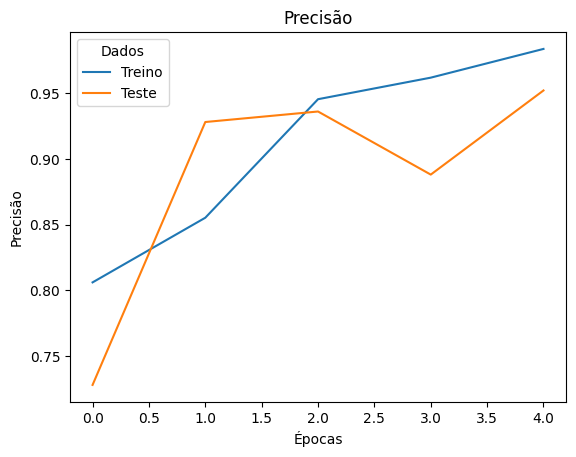

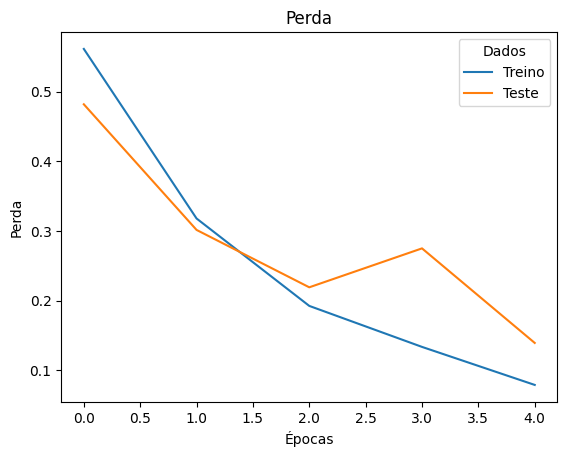

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].rename(columns={'acc': 'Treino', 'val_acc': 'Teste'}).plot(title='Precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend(title='Dados')
plt.show()

history_df[['loss', 'val_loss']].rename(columns={'loss': 'Treino', 'val_loss': 'Teste'}).plot(title='Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(title='Dados')
plt.show()


In [17]:
loss,acc = model.evaluate(x_train,treino['classe'])
print()
print ('Resultados do Treino :')
print()
print('Precisão: {:.2f}%'.format(acc * 100))

print()
print('Perda: {:.2f}%'.format(loss * 100))
print('-------------------------------------------------------------------')
loss,acc = model.evaluate(x_test,teste['classe'])
print()
print ('Resultados do Teste :')
print()
print('Precisão: {:.2f}%'.format(acc * 100))

print()
print('Perda: {:.2f}%'.format(loss * 100))

12/12 [==============================] - 1s 51ms/step - loss: 0.0514 - acc: 0.9918

Resultados do Treino :

Precisão: 99.18%

Perda: 5.14%
-------------------------------------------------------------------
4/4 [==============================] - 0s 83ms/step - loss: 0.1392 - acc: 0.9520

Resultados do Teste :

Precisão: 95.20%

Perda: 13.92%


####Salvando o modelo

In [18]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd /content/gdrive/MyDrive/Colab Notebooks/Machine Learning/Sprint 2/MVP/

!ls
#acessa a pasta montada
# lista o conteúdo da pasta

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/Sprint 2/MVP
'ML_MVP Notebook A'  'ML_MVP Notebook B 0707'
'ML_MVP Notebook B'   Ml_NotebookB.h5


In [19]:

# salvando o modelo
model.save("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/Sprint 2/MVP/Ml_NotebookB.h5")
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Conclusões Finais
Fizemos diversas rodadas de treino variando a quantidade de épocas. Foi com 5 épocas que obtivemos os melhores resultados.

Observamos que a perda diminui e a precisão aumenta ao longo das épocas no conjunto de treinamento, o que indica que o modelo está aprendendo a partir desse conjunto de dados. O mesmo comportamento observamos no conjunto de  teste, embora em alguns casos possam acontecer flutuações.

Ao final do treinamento, o modelo alcançou uma precisão acima de 90% para o conjunto de teste, o que nos leva a concluir que o modelo está aprendendo a partir dos dados, indicando um bom desempenho na classificação binária.
